<h1 style="text-align:center;">Workshop Training</h1> 

<h2 style="text-align:center;">LULC Analysis and Classification using Remote Sensing Data with Machine Learning Approach</h2> 

### Section 2: Data Structure, Exploratory Data Analysis and Machine Learning


In [388]:
import rasterio
import geopandas as gpd
import numpy as np

np.set_printoptions(suppress=True, precision=3)

Simplest way to read and visualize the satellite image file is to use `rasterio` lib as following

In [331]:
# Use as local workshop
# base_path = ''

# Use as running on Colab
base_path = 'https://github.com/thanthamky/rs-lc-dl/raw/refs/heads/main/'

In [332]:
image_file = base_path+'s2_samples/S2A_MSIL2A_20211215T035151_R104_T47PNS_20211217T045043_aoi_B08.tif'

with rasterio.open(image_file) as src:
    
    image_data = src.read()
    
print(image_data.shape)

(1, 390, 422)


Since the image data is already numpy array of image dimension, matplotlib is allowed to be used

In [333]:
import matplotlib.pyplot as plt

plot type is `imshow` function following by image structure as (height, width) if 2 dimension, with 3 dimensions have to arrange them to shape (height, width, channel)

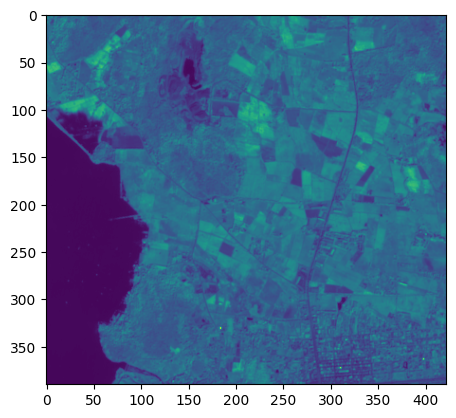

In [334]:
plt.imshow(image_data[0, :, :], norm='linear')

There are various raster files within a satellite dataset. Declare their paths into a list

In [337]:

image_files = [base_path+'s2_samples/S2A_MSIL2A_20211215T035151_R104_T47PNS_20211217T045043_aoi_B02.tif',
                base_path+'s2_samples/S2A_MSIL2A_20211215T035151_R104_T47PNS_20211217T045043_aoi_B03.tif',
                base_path+'s2_samples/S2A_MSIL2A_20211215T035151_R104_T47PNS_20211217T045043_aoi_B04.tif',
                base_path+'s2_samples/S2A_MSIL2A_20211215T035151_R104_T47PNS_20211217T045043_aoi_B08.tif',
                base_path+'s2_samples/S2A_MSIL2A_20211215T035151_R104_T47PNS_20211217T045043_aoi_B11.tif',
                base_path+'s2_samples/S2A_MSIL2A_20211215T035151_R104_T47PNS_20211217T045043_aoi_B12.tif']

Employ subplot capabilities to show multiple image to show

/var/folders/d1/pv_vgtx525d9v64kb01fvbz80000gn/T/ipykernel_45216/1369649732.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show() # show plot


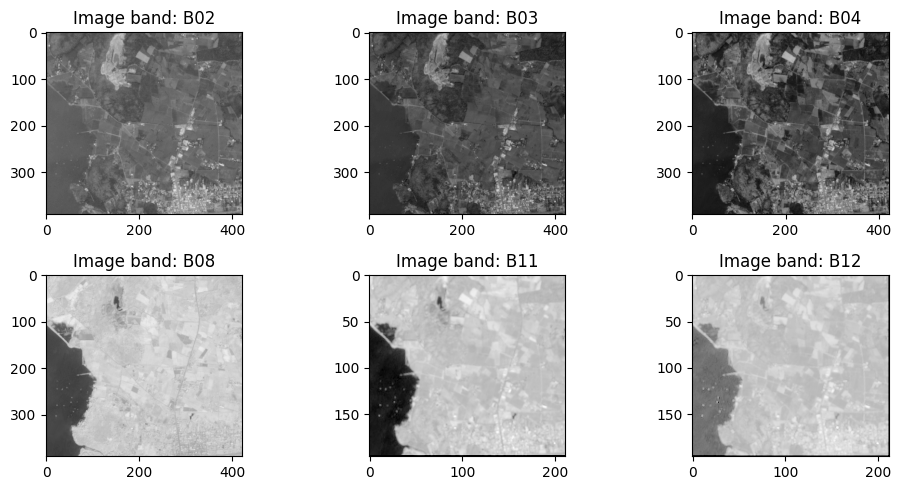

In [338]:
fig, ax = plt.subplots(2, 3, figsize=(10,5)) # create subplots by 2 rows, 3 cols, with figure size 10 x 5

ax = ax.flatten() # The axis to plot is row,col oriented, flatten them to single rows

for ax_idx, image_file in enumerate(image_files): # iterate over image files

    with rasterio.open(image_file) as src: # open raster file
        
        ax[ax_idx].imshow(src.read(1), norm='log', cmap='gray') # show image
        ax[ax_idx].set_title(f'Image band: {image_file[-7:-4]}') # set title

fig.tight_layout() # make figure layout more tight
fig.show() # show plot

All images are 1-band data. To visualize as colored image, we need to stack them into 3-bands. Also, we would demonstrate how the colors are made and how they show in _False Color Composite_ to enhance some objects more obvious and recognizable

In [341]:
color_composite_files  = [
    base_path+'s2_samples/S2A_MSIL2A_20211215T035151_R104_T47PNS_20211217T045043_aoi_B02.tif',
    base_path+'s2_samples/S2A_MSIL2A_20211215T035151_R104_T47PNS_20211217T045043_aoi_B03.tif',
    base_path+'s2_samples/S2A_MSIL2A_20211215T035151_R104_T47PNS_20211217T045043_aoi_B04.tif',
    base_path+'s2_samples/S2A_MSIL2A_20211215T035151_R104_T47PNS_20211217T045043_aoi_B08.tif',
]

color_composite_array = []

for raster_file in color_composite_files:
    
    with rasterio.open(raster_file) as src:
        color_composite_array.append(src.read(1))

color_composite_array = np.dstack(color_composite_array)

We construct the image datacube by R G B NIR bands corresponding to channels 0, 1, 2, 3 respectively

In [342]:
color_composite_array.shape

(390, 422, 4)

For more color enhancement, we make a std-based stretching for color profile

In [343]:
def enhance(arr, std_multiplier=2):
  
    mean = np.mean(arr)
    std = np.std(arr)

    # Calculate clipping bounds
    min_val = mean - std_multiplier * std # find Min
    max_val = mean + std_multiplier * std # find Max 

    # Clip the array
    clipped_arr = np.clip(arr, min_val, max_val) # Clip

    # Scale the clipped array to 0-255
    scaled_arr = (clipped_arr - min_val) / (max_val - min_val) * 255 # Scale to 0-255
    scaled_arr = scaled_arr.astype(np.uint8) # assign to uint8

    return scaled_arr

Then illustrate the _True Color Composite (TCC)_ and _False Color Composite (FCC)_ This FCC enhance the vegetation and water body more distinguishable which TCC is difficult to recognize

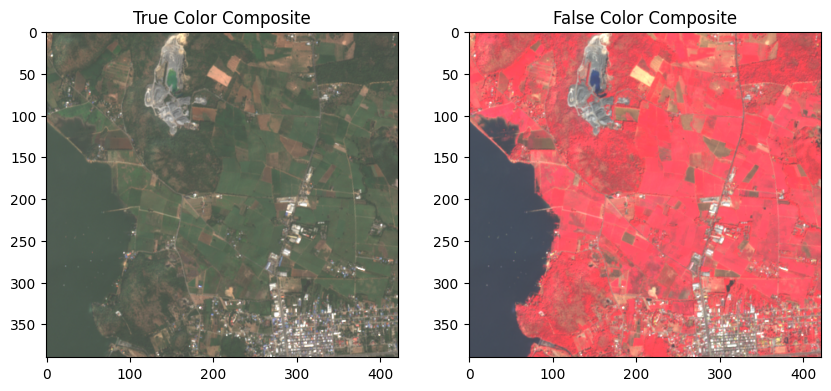

In [344]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(enhance(color_composite_array)[:,:, [2, 1, 0] ]) # TCC (R G B)
ax[0].set_title('True Color Composite')

ax[1].imshow(enhance(color_composite_array)[:,:, [3, 2, 1] ]) # FCC (NIR, R, G)
ax[1].set_title('False Color Composite')

plt.show()

## Index Image Calculation

You may know about NDVI or etc. index imagery in the lecture part. This will bring you to do actual calculation for NDVI, NDWI and NDBI for more hands on practical

In [345]:
red_file = base_path+'s2_samples/S2A_MSIL2A_20211215T035151_R104_T47PNS_20211217T045043_aoi_B04.tif'
nir_file = base_path+'s2_samples/S2A_MSIL2A_20211215T035151_R104_T47PNS_20211217T045043_aoi_B08.tif'

read the image data from files for both Red and NIR

In [346]:

with rasterio.open(red_file) as src: # open raster file
    red = src.read(1)
    
with rasterio.open(nir_file) as src: # open raster file
    nir = src.read(1) 

Check the shape of image

In [347]:
red.shape, nir.shape

((390, 422), (390, 422))

do NDVI calculation by equation

$$
NDVI = \frac{NIR - Red}{NIR + Red}
$$

 by this arithmetic operation

In [348]:
ndvi = (nir - red) / (nir + red + 1e-12) # add with epsilon to avoid division by zero

Visualize the NDVI result compared to the original Red and NIR

/var/folders/d1/pv_vgtx525d9v64kb01fvbz80000gn/T/ipykernel_45216/2301135659.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


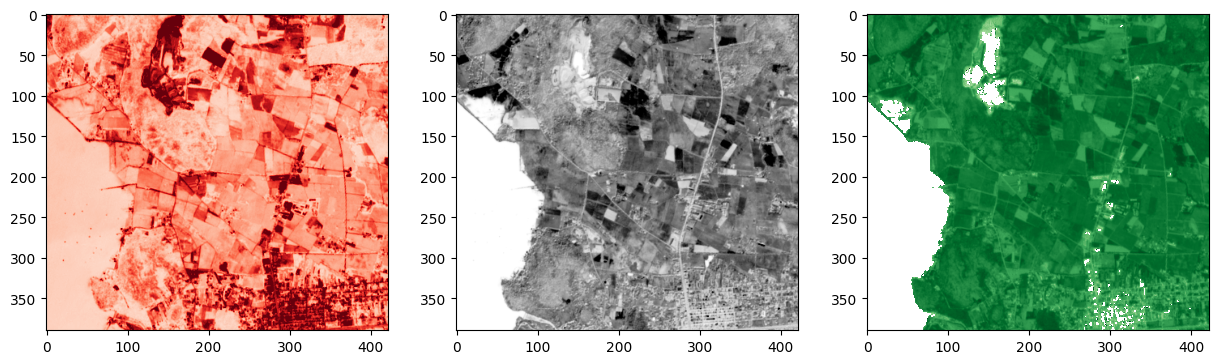

In [349]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(enhance(red), cmap='Reds')
# ax[0].set_title('Red')

ax[1].imshow(enhance(nir), cmap='Greys')
# ax[1].set_title('NIR')

ax[2].imshow(ndvi, cmap='Greens', norm='logit')
# ax[2].set_title('NDVI')

fig.show()

Try NDWI?

$$
NDWI = \frac{Green - NIR}{Green + NIR}
$$

/var/folders/d1/pv_vgtx525d9v64kb01fvbz80000gn/T/ipykernel_45216/86513235.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


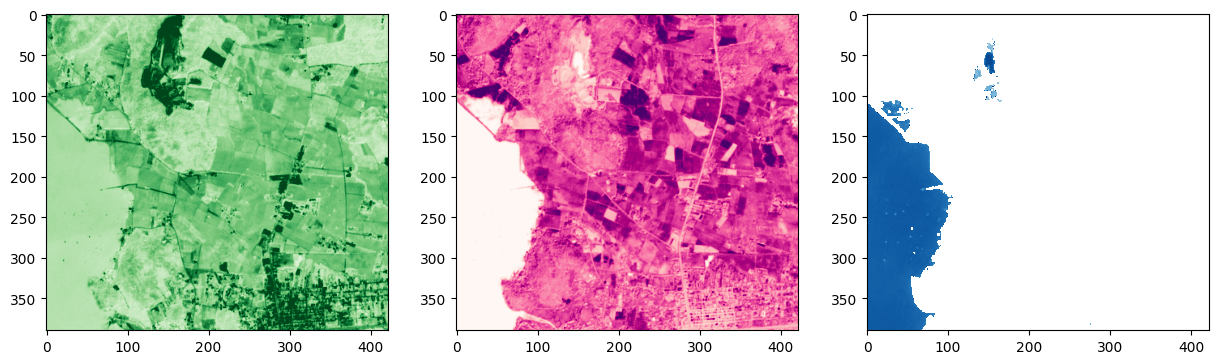

In [350]:
green_file = base_path+'s2_samples/S2A_MSIL2A_20211215T035151_R104_T47PNS_20211217T045043_aoi_B03.tif'
nir_file = base_path+'s2_samples/S2A_MSIL2A_20211215T035151_R104_T47PNS_20211217T045043_aoi_B08.tif'


with rasterio.open(green_file) as src: # open raster file
    green = src.read(1)
    
with rasterio.open(nir_file) as src: # open raster file
    nir = src.read(1) 
    

ndwi = (green - nir) / (green + nir + 1e-12) # add with epsilon to avoid division by zero


fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(enhance(green), cmap='Greens')
# ax[0].set_title('Green')

ax[1].imshow(enhance(nir), cmap='RdPu')
# ax[1].set_title('NIR')

ax[2].imshow(ndwi, cmap='Blues', norm='logit')
# ax[2].set_title('NDWI')

fig.show()

Try NDBI?

$$
NDBI = \frac{SWIR - NIR}{SWIR + NIR}
$$

In [351]:
swir_file = base_path+'s2_samples/S2A_MSIL2A_20211215T035151_R104_T47PNS_20211217T045043_aoi_B12.tif'
nir_file = base_path+'s2_samples/S2A_MSIL2A_20211215T035151_R104_T47PNS_20211217T045043_aoi_B08.tif'

Unfortunately, the SWIR file is natural 20 m. spatial resolution.

In [352]:
with rasterio.open(swir_file) as src: # open raster file
    swir = src.read(1)
    print(swir.shape)
    
with rasterio.open(nir_file) as src: # open raster file
    nir = src.read(1)
    print(nir.shape)

(196, 212)
(390, 422)


We have to resample the SWIR image into same dimension as NIR to allow calculation

In [353]:
from scipy import ndimage

def resample_with_zoom(arr, new_shape):
    zoom_factor = np.array(new_shape) / np.array(arr.shape)
    return ndimage.zoom(arr, zoom_factor, order=1)  # Adjust order for different interpolation

Check the dimensions of the SWIR

In [354]:
swir = resample_with_zoom(swir, nir.shape)

swir.shape

(390, 422)

Visulize the NDBI

/var/folders/d1/pv_vgtx525d9v64kb01fvbz80000gn/T/ipykernel_45216/1913364117.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


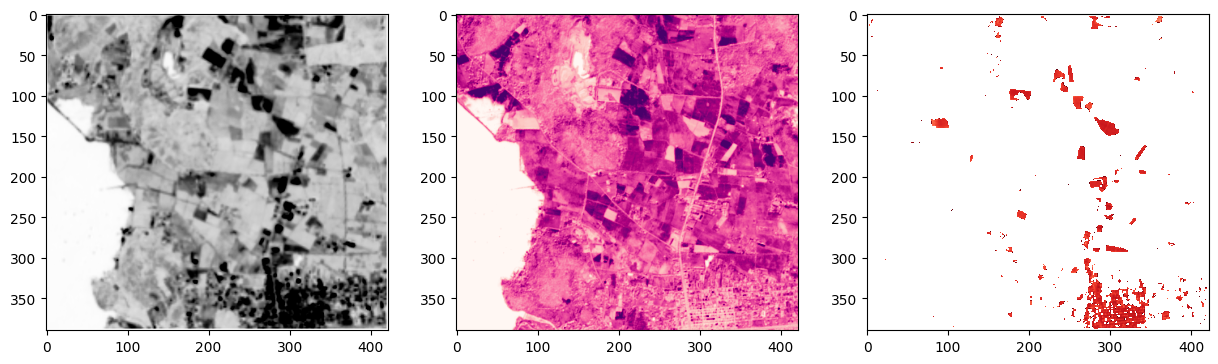

In [355]:

ndbi = (swir - nir) / (swir + nir + 1e-12) # add with epsilon to avoid division by zero


fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(enhance(swir), cmap='Greys')
# ax[0].set_title('SWIR')

ax[1].imshow(enhance(nir), cmap='RdPu')
# ax[1].set_title('NIR')

ax[2].imshow(ndbi, cmap='Reds', norm='logit')
# ax[2].set_title('NDBI')

fig.show()

After knowing how to read raster file, how about vector file like `.shp` or `.geojson`. Also, this workshop prefers `.geosjon` since out system or cloud-populated usually geojson with a single file handling.

<br>

lib `geopandas` can handle many file formats and simple to use like `pandas` dataframe

In [361]:
sample_file = base_path+'aoi_samples.geojson'

sample_points = gpd.read_file(sample_file)

How it looks like

In [362]:
sample_points

id  class_id                        geometry
0      0         3  POINT (575119.892 1640891.072)
1      1         3  POINT (573318.351 1641567.971)
2      2         1  POINT (572988.971 1643364.415)
3      3         4  POINT (573804.683 1642372.301)
4      4         4  POINT (573076.365 1641690.218)
..   ...       ...                             ...
852  852         3  POINT (571764.703 1643893.533)
853  853         1  POINT (575024.216 1641388.558)
854  854         1  POINT (571803.205 1644676.474)
855  855         1  POINT (573130.942 1643395.646)
856  856         1  POINT (572590.837 1643381.111)

[857 rows x 3 columns]

Or show in interactive map widget like, folium map

In [363]:
sample_points.explore(tiles='https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}',
                        attr='Google Satellite Hybrd',)

On the other hand, geometry of points can be accessible by this

In [364]:
sample_points.geometry

0      POINT (575119.892 1640891.072)
1      POINT (573318.351 1641567.971)
2      POINT (572988.971 1643364.415)
3      POINT (573804.683 1642372.301)
4      POINT (573076.365 1641690.218)
                    ...              
852    POINT (571764.703 1643893.533)
853    POINT (575024.216 1641388.558)
854    POINT (571803.205 1644676.474)
855    POINT (573130.942 1643395.646)
856    POINT (572590.837 1643381.111)
Name: geometry, Length: 857, dtype: geometry

This is an essential process. we would use those point geometry to extract raster values where the points are. and save into its geodataframe columns. First, create a function that do raster values sampling

In [365]:
def extract_raster_values_to_points(raster_file, point_geometry):
    with rasterio.open(raster_file) as src: 
        values = [] 
        for point in point_geometry:
            #print(point)
            coords = (point.x, point.y)
            value = list(src.sample([coords]))[0][0]
            values.append(value) 
    return values

Then, we can iterate over image file list to do raster values sampling and dump it to existing geodataframe columns like

In [ ]:
for raster_file in image_files:
    
    band_name = raster_file[-7:-4] # Get Band name e.g. B02, B08
    
    sample_points[band_name] = extract_raster_values_to_points(raster_file, sample_points.geometry)

This is how it looks like

In [368]:
sample_points

id  class_id                        geometry  B02  B03   B04   B08  \
0      0         3  POINT (575119.892 1640891.072)  644  958  1124  2814   
1      1         3  POINT (573318.351 1641567.971)  363  631   554  1992   
2      2         1  POINT (572988.971 1643364.415)  286  441   277  3134   
3      3         4  POINT (573804.683 1642372.301)  247  417   335  1670   
4      4         4  POINT (573076.365 1641690.218)  428  765   450  4744   
..   ...       ...                             ...  ...  ...   ...   ...   
852  852         3  POINT (571764.703 1643893.533)  429  685   651  2854   
853  853         1  POINT (575024.216 1641388.558)  501  720   590  2696   
854  854         1  POINT (571803.205 1644676.474)  308  473   463  2058   
855  855         1  POINT (573130.942 1643395.646)  321  588   408  2812   
856  856         1  POINT (572590.837 1643381.111)  373  554   392  2916   

      B11   B12  
0    3526  2286  
1    1917   982  
2    1662   757  
3    1564   723  
4    2399  1236  
..    ...   ...  
852  2132  1221  
853  1943  1258  
854  1920  1061  
855  1878   869  
856  1512   693  

[857 rows x 9 columns]

## Exploratory Data Analysis

The step of dataset preparation was done. Before beginning for anay analysis, exploratory analysis is needed to understanding how balance, distribute, histogram and etc. neccessary to help more intuition of dataset

In [369]:
class_counts = sample_points['class_id'].value_counts().sort_index().to_dict()

class_counts

{1: 248, 3: 46, 4: 382, 5: 79, 6: 9, 8: 91, 9: 2}

Reference data was constructued using `class_id` code which is not readable by the human. there should be some description of class_id using `Dictionary`

In [370]:
class_name = {
    1: 'Vegetation',
    2: 'Shrubland',
    3: 'Grasland',
    4: 'Cropland',
    5: 'Built-up',
    6: 'Bareland',
    7: 'Snow and Ice',
    8: 'Water',
    9: 'Herbal Wetland'
}

class_color = {
    1: 'darkgreen',
    2: 'orange',
    3: 'yellow',
    4: 'magenta',
    5: 'red',
    6: 'gray',
    7: 'white',
    8: 'blue',
    9: 'purple'
}

First of all is sample balance plot. It shows number of samples of each class_id by bar chart

/var/folders/d1/pv_vgtx525d9v64kb01fvbz80000gn/T/ipykernel_45216/1463279737.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


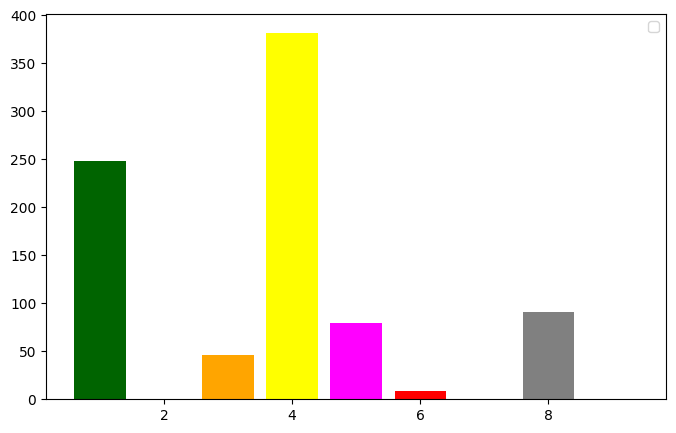

In [372]:
plt.figure(figsize=(8,5))

plt.bar(class_counts.keys(), class_counts.values(), color=class_color.values())

# for class_id, counts in class_counts.items():
    
#     plt.text(class_id-0.20, counts+5, f'{counts}')
    

# plt.xticks(list(class_name.keys()), list(class_name.values()), rotation=45)

# plt.ylabel('Sample counts')
# plt.xlabel('Land cover type')

# plt.title('Sample counts of dataset')

plt.legend()
plt.show()

To show histogram of each LULC class, pyplot implement `plt.hist`

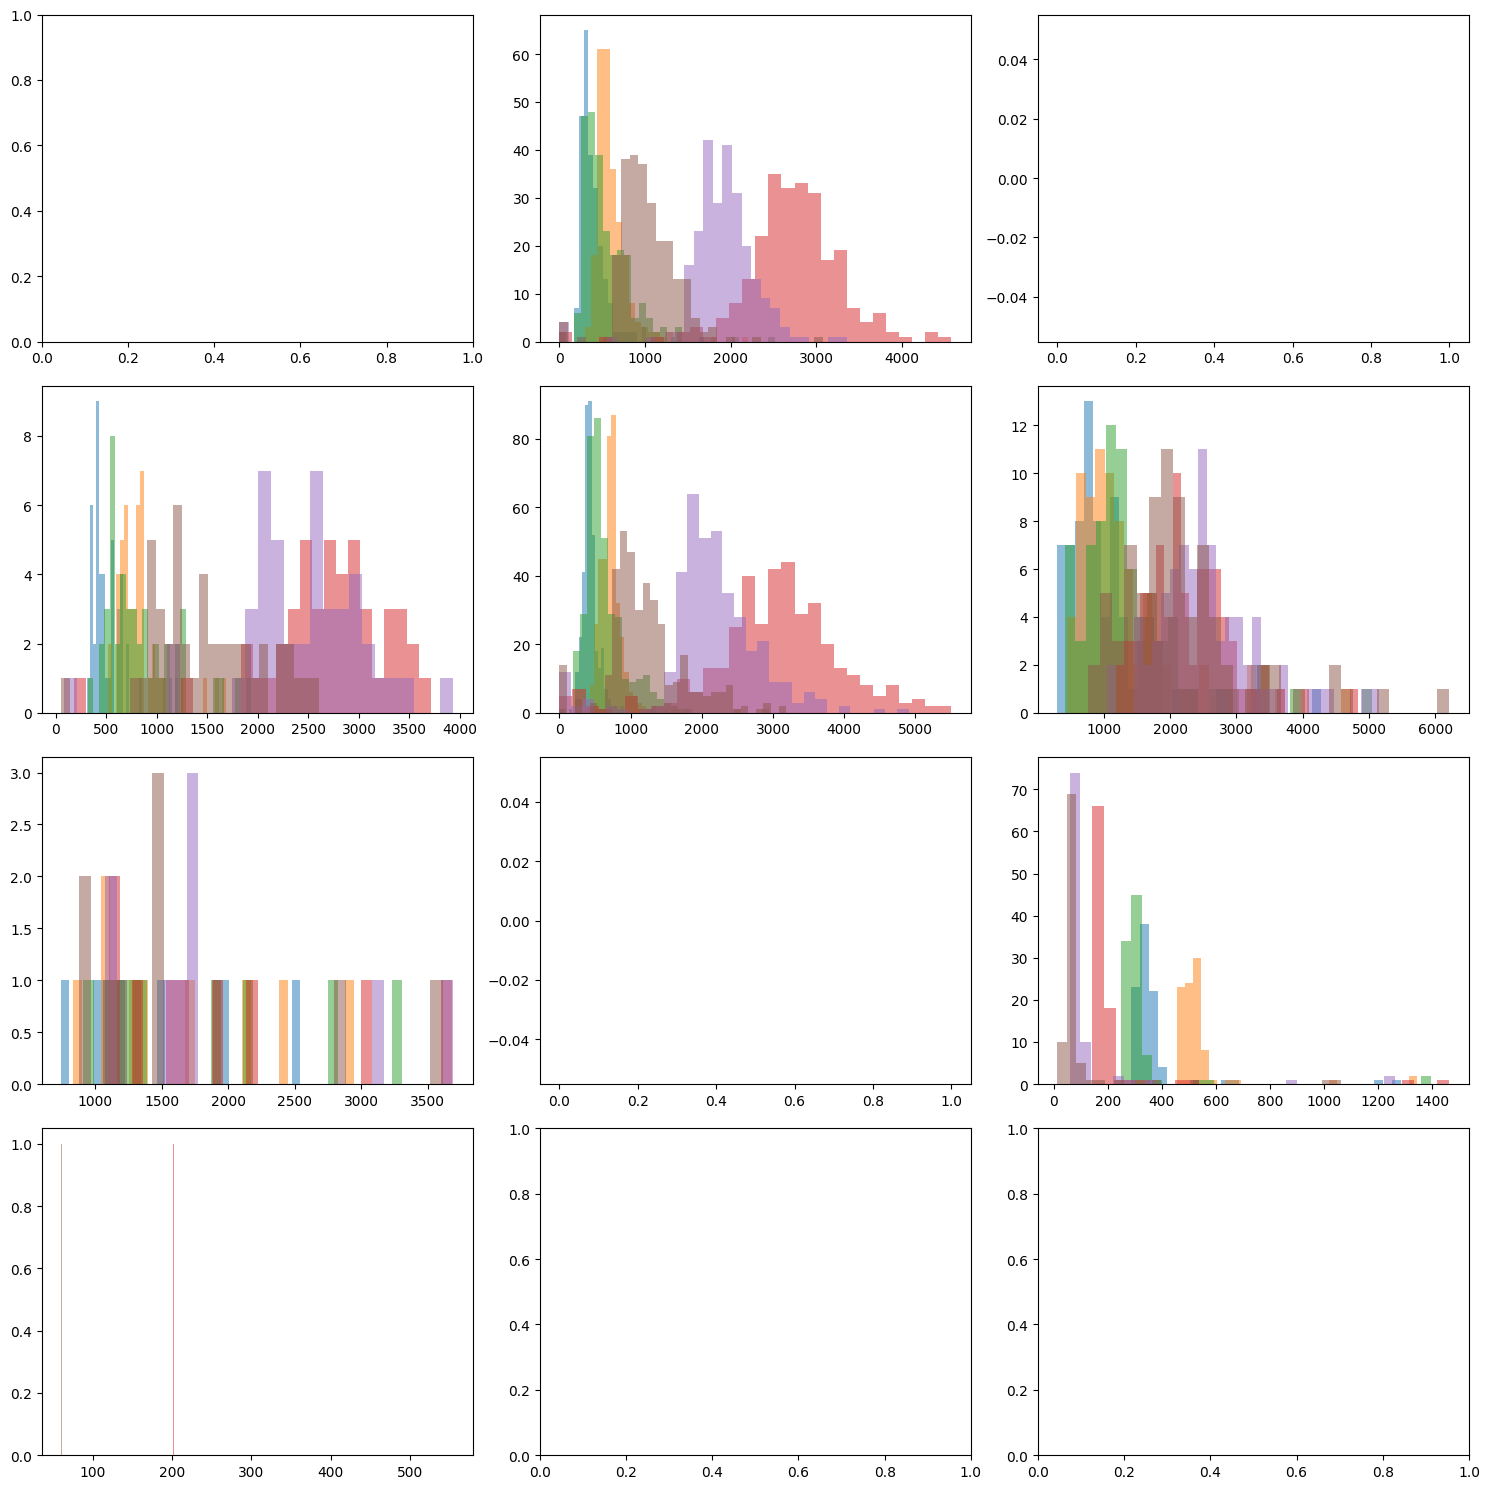

In [373]:
fig, ax = plt.subplots(4, 3, figsize=(15,15))

ax = ax.flatten()

for class_id, class_label in class_name.items():

    ax[class_id].hist(sample_points[sample_points['class_id'] == class_id].loc[:, 'B02'], label='Blue', bins=30, alpha=.5)
    ax[class_id].hist(sample_points[sample_points['class_id'] == class_id].loc[:, 'B03'], label='Green', bins=30, alpha=.5)
    ax[class_id].hist(sample_points[sample_points['class_id'] == class_id].loc[:, 'B04'], label='Red', bins=30, alpha=.5)
    ax[class_id].hist(sample_points[sample_points['class_id'] == class_id].loc[:, 'B08'], label='NIR', bins=30, alpha=.5)
    ax[class_id].hist(sample_points[sample_points['class_id'] == class_id].loc[:, 'B11'], label='SWIR16', bins=30, alpha=.5)
    ax[class_id].hist(sample_points[sample_points['class_id'] == class_id].loc[:, 'B12'], label='SWIR22', bins=30, alpha=.5)

    # ax[class_id].set_title(f'LULC Class {class_id}: {class_label}')
    # ax[class_id].legend()
    
fig.tight_layout()

As well as the spectral signature, LULC class is able to be visualized as spectral profile by samples summary

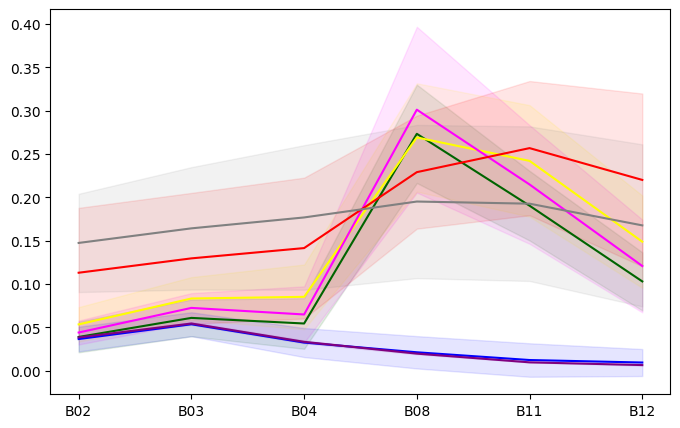

In [375]:
plt.figure(figsize=(8, 5))

for class_id in class_name.keys():
    
    mean_spectral = sample_points[sample_points['class_id'] == class_id].iloc[:, 3:].mean(axis=0) / 10000
    std_spectral = sample_points[sample_points['class_id'] == class_id].iloc[:, 3:].std(axis=0) / 10000

    upper_std = mean_spectral + std_spectral
    lower_std = mean_spectral - std_spectral 
    
    plt.plot(mean_spectral, color=class_color[class_id], label=f'{class_name[class_id]}')
    plt.fill_between(mean_spectral.index, upper_std, lower_std, color=class_color[class_id], alpha=.1) 

# plt.xticks(np.arange(len(mean_spectral)), ['B02', 'B03', 'B04', 'B08', 'B11', 'B12'])

# plt.ylabel('reflectance ratio')
# plt.xlabel('Spectral band')

# plt.title('Spectral Signature of LULC')
# plt.legend()

plt.show()

The previous plot may too pickling to show, it is better to smoothen them by this function

In [376]:
from scipy.interpolate import make_interp_spline

def smoothen_line(x, y):
    
    X_Y_Spline = make_interp_spline(x, y)
 
    # Returns evenly spaced numbers
    # over a specified interval.
    X_ = np.linspace(x.min(), x.max(), 500)
    Y_ = X_Y_Spline(X_)
    
    return X_, Y_

Try to plot smoother spectral signature line

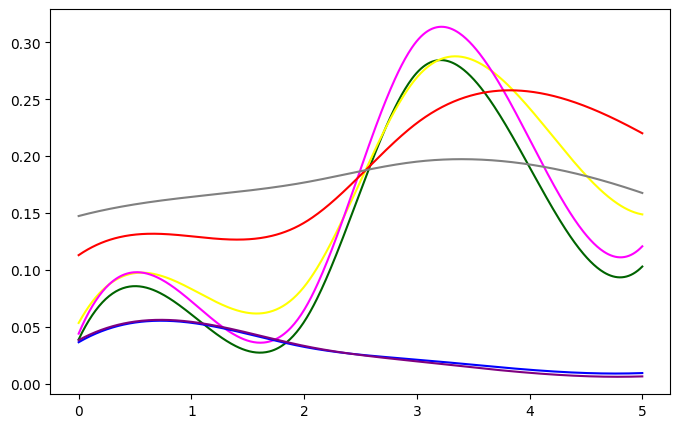

In [377]:
plt.figure(figsize=(8, 5))

for class_id in class_counts.keys():
    
    mean_spectral = sample_points[sample_points['class_id'] == class_id].iloc[:, 3:].mean(axis=0) / 10000
    std_spectral = sample_points[sample_points['class_id'] == class_id].iloc[:, 3:].std(axis=0) / 10000

    upper_std = mean_spectral + std_spectral
    lower_std = mean_spectral - std_spectral 
    
    idx, smooth_line = smoothen_line(np.arange(len(mean_spectral)), mean_spectral)
    
    plt.plot(idx, smooth_line, color=class_color[class_id], label=f'{class_name[class_id]}')


#plt.xticks(np.arange(len(mean_spectral)), ['B02', 'B03', 'B04', 'B08', 'B11', 'B12'])

#plt.ylabel('reflectance ratio')
#plt.xlabel('Spectral band')

#plt.title('Spectral Signature of LULC')

#plt.legend()
plt.show()

## Try Classical Machine Learning Models

In [378]:
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import SVC

from sklearn.metrics import classification_report, confusion_matrix

Fisr step of doing any ML analysis is to seperate the X (independent) and y (dependent). Our X is reflectance for each channel

In [379]:
X = sample_points.iloc[:, 3:]
X

B02  B03   B04   B08   B11   B12
0    644  958  1124  2814  3526  2286
1    363  631   554  1992  1917   982
2    286  441   277  3134  1662   757
3    247  417   335  1670  1564   723
4    428  765   450  4744  2399  1236
..   ...  ...   ...   ...   ...   ...
852  429  685   651  2854  2132  1221
853  501  720   590  2696  1943  1258
854  308  473   463  2058  1920  1061
855  321  588   408  2812  1878   869
856  373  554   392  2916  1512   693

[857 rows x 6 columns]

And y is class_id

In [380]:
y = sample_points.loc[:, 'class_id']
y

0      3
1      3
2      1
3      4
4      4
      ..
852    3
853    1
854    1
855    1
856    1
Name: class_id, Length: 857, dtype: int32

Since the X values represent full number which is might be not same scale of each channel. Normalization or Standardization are needed in order to normalize the values to same scale. This helps the model being more easier to converge to optimal point

In [381]:
scaler = StandardScaler()

scaler.fit(X)

X_scaled = scaler.transform(X)

Then split the Training and Testing set

In [382]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, stratify=y)

print(f'Training set: {X_train.shape}, {y_train.shape}')
print(f'Training set: {X_test.shape}, {y_test.shape}')

Training set: (599, 6), (599,)
Training set: (258, 6), (258,)


Instaniate the model and try train it

In [383]:
model = LogisticRegression()

model.fit(X_train, y_train)

LogisticRegression()

No output coming from previous cell because it is training step. prediction is there for trying to forward the values to get result from model (Inferencing)

In [385]:
y_pred = model.predict(X_test)

Show the accuracy report

In [386]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.76      0.60      0.67        75
           3       0.00      0.00      0.00        14
           4       0.68      0.85      0.76       115
           5       0.69      0.75      0.72        24
           6       0.50      0.33      0.40         3
           8       0.96      0.96      0.96        27

    accuracy                           0.73       258
   macro avg       0.60      0.58      0.59       258
weighted avg       0.70      0.73      0.70       258



/opt/anaconda3/envs/ttg-tes/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/ttg-tes/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/ttg-tes/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Now, simplest classification model was done. Deep learning actuualy works same way of logistic regression. It is nescessary to dig down on how it works. This illustrates and helps to understand deep learning architect better.

<br>

Start from common formula of linear algrbra and logistic math

$$
h_\theta (x) = \theta^TX + b
$$


$$ 
W^* = argmax_w \sum_{i=1}^{n} \sigma(h_\theta (x))
$$

<br>

Fortunately, by this math, scikit learn's logistic regression parameters can be accessible by this

In [389]:
model.coef_ # theta

array([[ 0.759, -3.277,  1.141,  1.455,  0.53 , -0.774],
       [-1.275,  1.422, -0.549, -0.017,  1.681, -0.4  ],
       [-2.768,  1.368,  0.169,  1.054,  0.296,  0.259],
       [ 1.271, -0.314, -0.907, -0.112, -0.387,  2.053],
       [ 1.41 ,  0.178,  0.385, -0.527, -0.237, -0.058],
       [ 0.561,  0.624, -0.102, -1.412, -1.395, -0.688],
       [ 0.041, -0.001, -0.136, -0.441, -0.488, -0.391]])

In [391]:
model.intercept_ # bias

array([ 2.99 ,  1.438,  3.538,  1.129, -2.686, -3.255, -3.154])

Relying on the math of $\theta^TX +b$ we can calculate easily by dot product as mentioned in first section. the thing left to do is sigmoid function

$$
\sigma (x) = \frac {1}{1 + e^{-x}}
$$

$e$ value we can use `math` lib as constant calling

In [392]:
import math

math.e

2.718281828459045

create a sigmoid function

In [393]:
def sigmoid(x):
    
    return 1/(1 + np.exp(-x)) 

In terms of $\sigma (\theta^TX + b)$, implement the math

In [394]:
x = sigmoid(X_test @ model.coef_[0] + model.intercept_[0])
x

array([0.941, 0.989, 0.984, 0.996, 0.014, 0.999, 0.99 , 0.977, 0.946,
       0.671, 0.992, 0.995, 0.973, 0.975, 0.679, 0.995, 0.889, 0.976,
       0.98 , 0.957, 0.902, 0.037, 0.96 , 0.955, 0.745, 0.989, 0.98 ,
       0.657, 0.951, 0.999, 0.989, 0.982, 0.963, 0.998, 0.987, 0.873,
       0.979, 0.936, 0.985, 0.989, 0.94 , 0.977, 0.681, 0.986, 0.96 ,
       0.972, 0.974, 0.957, 0.992, 0.972, 0.836, 0.432, 0.969, 0.96 ,
       0.977, 0.992, 0.987, 0.961, 0.991, 0.983, 0.996, 0.952, 0.975,
       0.964, 0.994, 0.679, 0.951, 0.945, 0.674, 0.022, 0.985, 0.961,
       0.683, 0.321, 0.951, 0.988, 0.716, 0.964, 0.   , 0.997, 0.988,
       0.975, 0.   , 0.993, 0.978, 0.99 , 0.861, 0.957, 0.995, 0.992,
       0.986, 0.69 , 0.989, 0.981, 0.975, 0.982, 0.959, 0.964, 0.989,
       0.999, 0.748, 0.983, 0.969, 0.981, 0.965, 0.974, 0.973, 0.96 ,
       0.982, 0.979, 0.96 , 0.99 , 0.96 , 0.976, 0.979, 0.975, 0.997,
       0.986, 0.695, 0.65 , 0.987, 0.99 , 0.991, 0.986, 0.986, 0.069,
       0.97 , 0.69 ,

which x is shape equals to length of inputs X_test

In [395]:
x.shape

(258,)

That math is to calculate only one single-modal (1 class probabilities). To calculate all modals, iterate over sub model like

In [396]:
out = []

for i in range(len(model.intercept_)):
    
    out.append(sigmoid(X_test @ model.coef_[i] + model.intercept_[i]))

Examine the shape of outputs. There is a shape (samples, classes)

In [397]:
np.dstack(out).shape

(1, 258, 7)

Each class axis, they are probability of each class, we can apply $argmax$ to pick most sigmoid value to be a class output

In [398]:
pred = np.dstack(out).squeeze().argmax(axis=1)
pred

array([2, 2, 0, 2, 3, 0, 0, 0, 2, 5, 0, 0, 2, 2, 5, 2, 2, 2, 0, 2, 2, 3,
       2, 2, 5, 0, 2, 5, 2, 0, 2, 2, 2, 2, 2, 3, 2, 2, 2, 0, 2, 2, 5, 2,
       2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 5,
       2, 2, 5, 4, 2, 2, 5, 3, 2, 0, 5, 2, 3, 2, 0, 2, 3, 0, 2, 0, 3, 2,
       0, 0, 0, 5, 0, 2, 2, 2, 2, 2, 2, 0, 5, 2, 2, 2, 2, 0, 2, 2, 2, 0,
       2, 0, 0, 0, 2, 2, 0, 2, 5, 5, 0, 0, 0, 0, 2, 3, 2, 5, 2, 0, 3, 2,
       0, 2, 0, 2, 2, 2, 0, 3, 2, 0, 2, 0, 2, 2, 5, 2, 3, 2, 5, 5, 2, 2,
       5, 2, 2, 2, 0, 5, 5, 3, 3, 2, 2, 2, 2, 3, 0, 3, 2, 3, 5, 2, 2, 3,
       3, 3, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 3, 2,
       2, 0, 2, 5, 0, 2, 2, 0, 0, 5, 3, 0, 2, 0, 2, 0, 2, 5, 0, 2, 2, 0,
       0, 2, 0, 0, 2, 3, 2, 0, 2, 2, 2, 3, 2, 2, 5, 2, 3, 2, 2, 2, 0, 0,
       4, 2, 2, 3, 2, 2, 2, 2, 2, 2, 5, 2, 5, 2, 2, 2])

Translate the class index to class_id

In [399]:
pred = np.asarray([model.classes_[i] for i in pred])
pred

array([4, 4, 1, 4, 5, 1, 1, 1, 4, 8, 1, 1, 4, 4, 8, 4, 4, 4, 1, 4, 4, 5,
       4, 4, 8, 1, 4, 8, 4, 1, 4, 4, 4, 4, 4, 5, 4, 4, 4, 1, 4, 4, 8, 4,
       4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 1, 1, 1, 4, 4, 4, 4, 8,
       4, 4, 8, 6, 4, 4, 8, 5, 4, 1, 8, 4, 5, 4, 1, 4, 5, 1, 4, 1, 5, 4,
       1, 1, 1, 8, 1, 4, 4, 4, 4, 4, 4, 1, 8, 4, 4, 4, 4, 1, 4, 4, 4, 1,
       4, 1, 1, 1, 4, 4, 1, 4, 8, 8, 1, 1, 1, 1, 4, 5, 4, 8, 4, 1, 5, 4,
       1, 4, 1, 4, 4, 4, 1, 5, 4, 1, 4, 1, 4, 4, 8, 4, 5, 4, 8, 8, 4, 4,
       8, 4, 4, 4, 1, 8, 8, 5, 5, 4, 4, 4, 4, 5, 1, 5, 4, 5, 8, 4, 4, 5,
       5, 5, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 5, 4,
       4, 1, 4, 8, 1, 4, 4, 1, 1, 8, 5, 1, 4, 1, 4, 1, 4, 8, 1, 4, 4, 1,
       1, 4, 1, 1, 4, 5, 4, 1, 4, 4, 4, 5, 4, 4, 8, 4, 5, 4, 4, 4, 1, 1,
       6, 4, 4, 5, 4, 4, 4, 4, 4, 4, 8, 4, 8, 4, 4, 4], dtype=int32)

try out own developed logistic regression classification

In [400]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           1       0.76      0.60      0.67        75
           3       0.00      0.00      0.00        14
           4       0.68      0.85      0.76       115
           5       0.69      0.75      0.72        24
           6       0.50      0.33      0.40         3
           8       0.96      0.96      0.96        27

    accuracy                           0.73       258
   macro avg       0.60      0.58      0.59       258
weighted avg       0.70      0.73      0.70       258



/opt/anaconda3/envs/ttg-tes/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/ttg-tes/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/ttg-tes/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

As well as cofusion matrix that helps to identify correctness and misclassified counts

In [401]:
cm = confusion_matrix(y_test, pred)
cm

array([[45,  0, 27,  3,  0,  0],
       [ 0,  0, 13,  1,  0,  0],
       [14,  0, 98,  2,  0,  1],
       [ 0,  0,  5, 18,  1,  0],
       [ 0,  0,  0,  2,  1,  0],
       [ 0,  0,  1,  0,  0, 26]])

Declare textual labels for more understanding

In [402]:
labels = [class_name[class_id] for class_id in class_counts.keys()]
labels

['Vegetation',
 'Grasland',
 'Cropland',
 'Built-up',
 'Bareland',
 'Water',
 'Herbal Wetland']

Decorate the Confusion matrix for more intuition

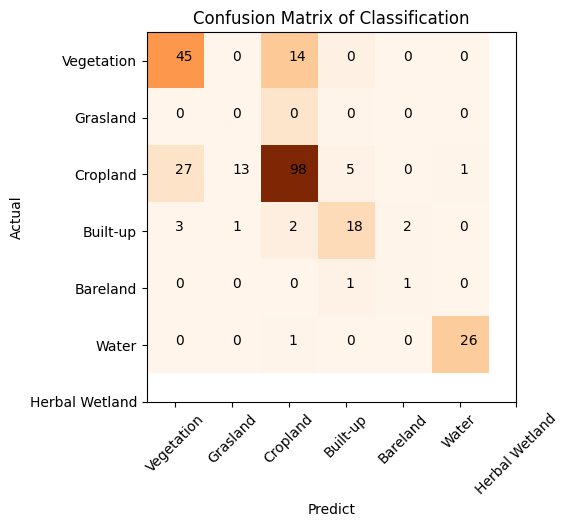

In [403]:
plt.imshow(cm, cmap='Oranges') # Show the colormap first

for i in range(cm.shape[0]): # for each row
    
    for j in range(cm.shape[1]): # for each col
        
        plt.text(i, j, cm[i, j]) # plot text of counts
        
plt.xticks(np.arange(len(labels)), labels, rotation=45) # define x labels
plt.yticks(np.arange(len(labels)), labels) # define y labels
        
plt.xlabel('Predict') # set x label
plt.ylabel('Actual') # set y label

plt.title('Confusion Matrix of Classification') # set title

plt.show()

#### Try Decision Tree

Decision Tree is a popular baseline model for classification problem. It is very intuitive to interpret classification problem.

Also, it is rule-based decision which very easy to understand how the model works

![](https://static.javatpoint.com/tutorial/machine-learning/images/decision-tree-classification-algorithm.png)

Model creation is from __impurity__ value of a spliting the feature axis based on class labels. There are 2 kinds of impurity functions, __Gini__ and __Entropy__.

$$
G = 1 - \sum_{i=1}^C{p_i^2}
$$

$$
H = - \sum_{i=1}^C{p_ilog_2(p_i)}
$$

The impurity indicates how diversity of answer within a group of data. The decision tree will find the best split of features with lowest impurity value to define the mode criteria

![](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS66--gCliM307ZPXAwstdCBLkxeiEbW2lthA&s)

Show example of impurity calculation with how to select best split

In [404]:
feature = np.random.randint(low=1, high=20, size=10)
target = np.random.randint(low=0, high=2, size=10)

we sort the `feature` and `target`

In [405]:
ind = np.argsort(feature)
ind

array([7, 2, 0, 1, 6, 8, 9, 5, 4, 3])

Apply sort value

In [406]:
feature = feature[ind]
target = target[ind]

feature, target

(array([ 1,  2,  5,  5,  6,  7,  8, 11, 15, 17]),
 array([0, 0, 0, 0, 0, 1, 1, 0, 1, 0]))

We come up the function to calculate impurity both of entropy and gini

In [407]:
def gini(y):
    p = np.unique(y, return_counts=True)[1] / y.shape[0]
    gini = 1-np.sum(p**2)
    return(gini)

def entropy(y):
    p = np.unique(y, return_counts=True)[1] / y.shape[0]
    entropy = np.sum(-p*np.log2(p+1e-9))
    return(entropy)


This code show the running split portion of feature items and calculate the sum impurity to find best split given lowest impurity value

In [408]:
for split_index in range(1, len(feature)):
    
    split_left = target[:split_index]
    split_right = target[split_index:]
    
    sum_gini = 0.0
    
    sum_gini += gini(split_left) * (len(split_left) / len(target))
    sum_gini += gini(split_right)* (len(split_right)/ len(target))
    
    print(f'Split {split_left} | {split_right} -> impurity: {sum_gini}')

Split [0] | [0 0 0 0 1 1 0 1 0] -> impurity: 0.39999999999999997
Split [0 0] | [0 0 0 1 1 0 1 0] -> impurity: 0.375
Split [0 0 0] | [0 0 1 1 0 1 0] -> impurity: 0.3428571428571429
Split [0 0 0 0] | [0 1 1 0 1 0] -> impurity: 0.3
Split [0 0 0 0 0] | [1 1 0 1 0] -> impurity: 0.24
Split [0 0 0 0 0 1] | [1 0 1 0] -> impurity: 0.3666666666666666
Split [0 0 0 0 0 1 1] | [0 1 0] -> impurity: 0.419047619047619
Split [0 0 0 0 0 1 1 0] | [1 0] -> impurity: 0.4
Split [0 0 0 0 0 1 1 0 1] | [0] -> impurity: 0.39999999999999997


Best split will be at lowest. The split determines next left and right nodes in next depth. we can define how depth the branch to answer. the high impurity of leaf will select most proportion of left over classes to answer at the leaf.

So, we do decision tree in real model

In [409]:
tree = DecisionTreeClassifier(max_depth=5)

tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

predict the output class from trained tree

In [410]:
tree_pred = tree.predict(X_test)

Check the correctness metric

In [411]:
print(classification_report(y_test, tree_pred))

              precision    recall  f1-score   support

           1       0.68      0.64      0.66        75
           3       0.00      0.00      0.00        14
           4       0.65      0.85      0.74       115
           5       0.75      0.38      0.50        24
           6       0.00      0.00      0.00         3
           8       0.96      0.85      0.90        27

    accuracy                           0.69       258
   macro avg       0.51      0.45      0.47       258
weighted avg       0.66      0.69      0.66       258



/opt/anaconda3/envs/ttg-tes/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/ttg-tes/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/ttg-tes/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Tree is the only one model that has built-in visualizer

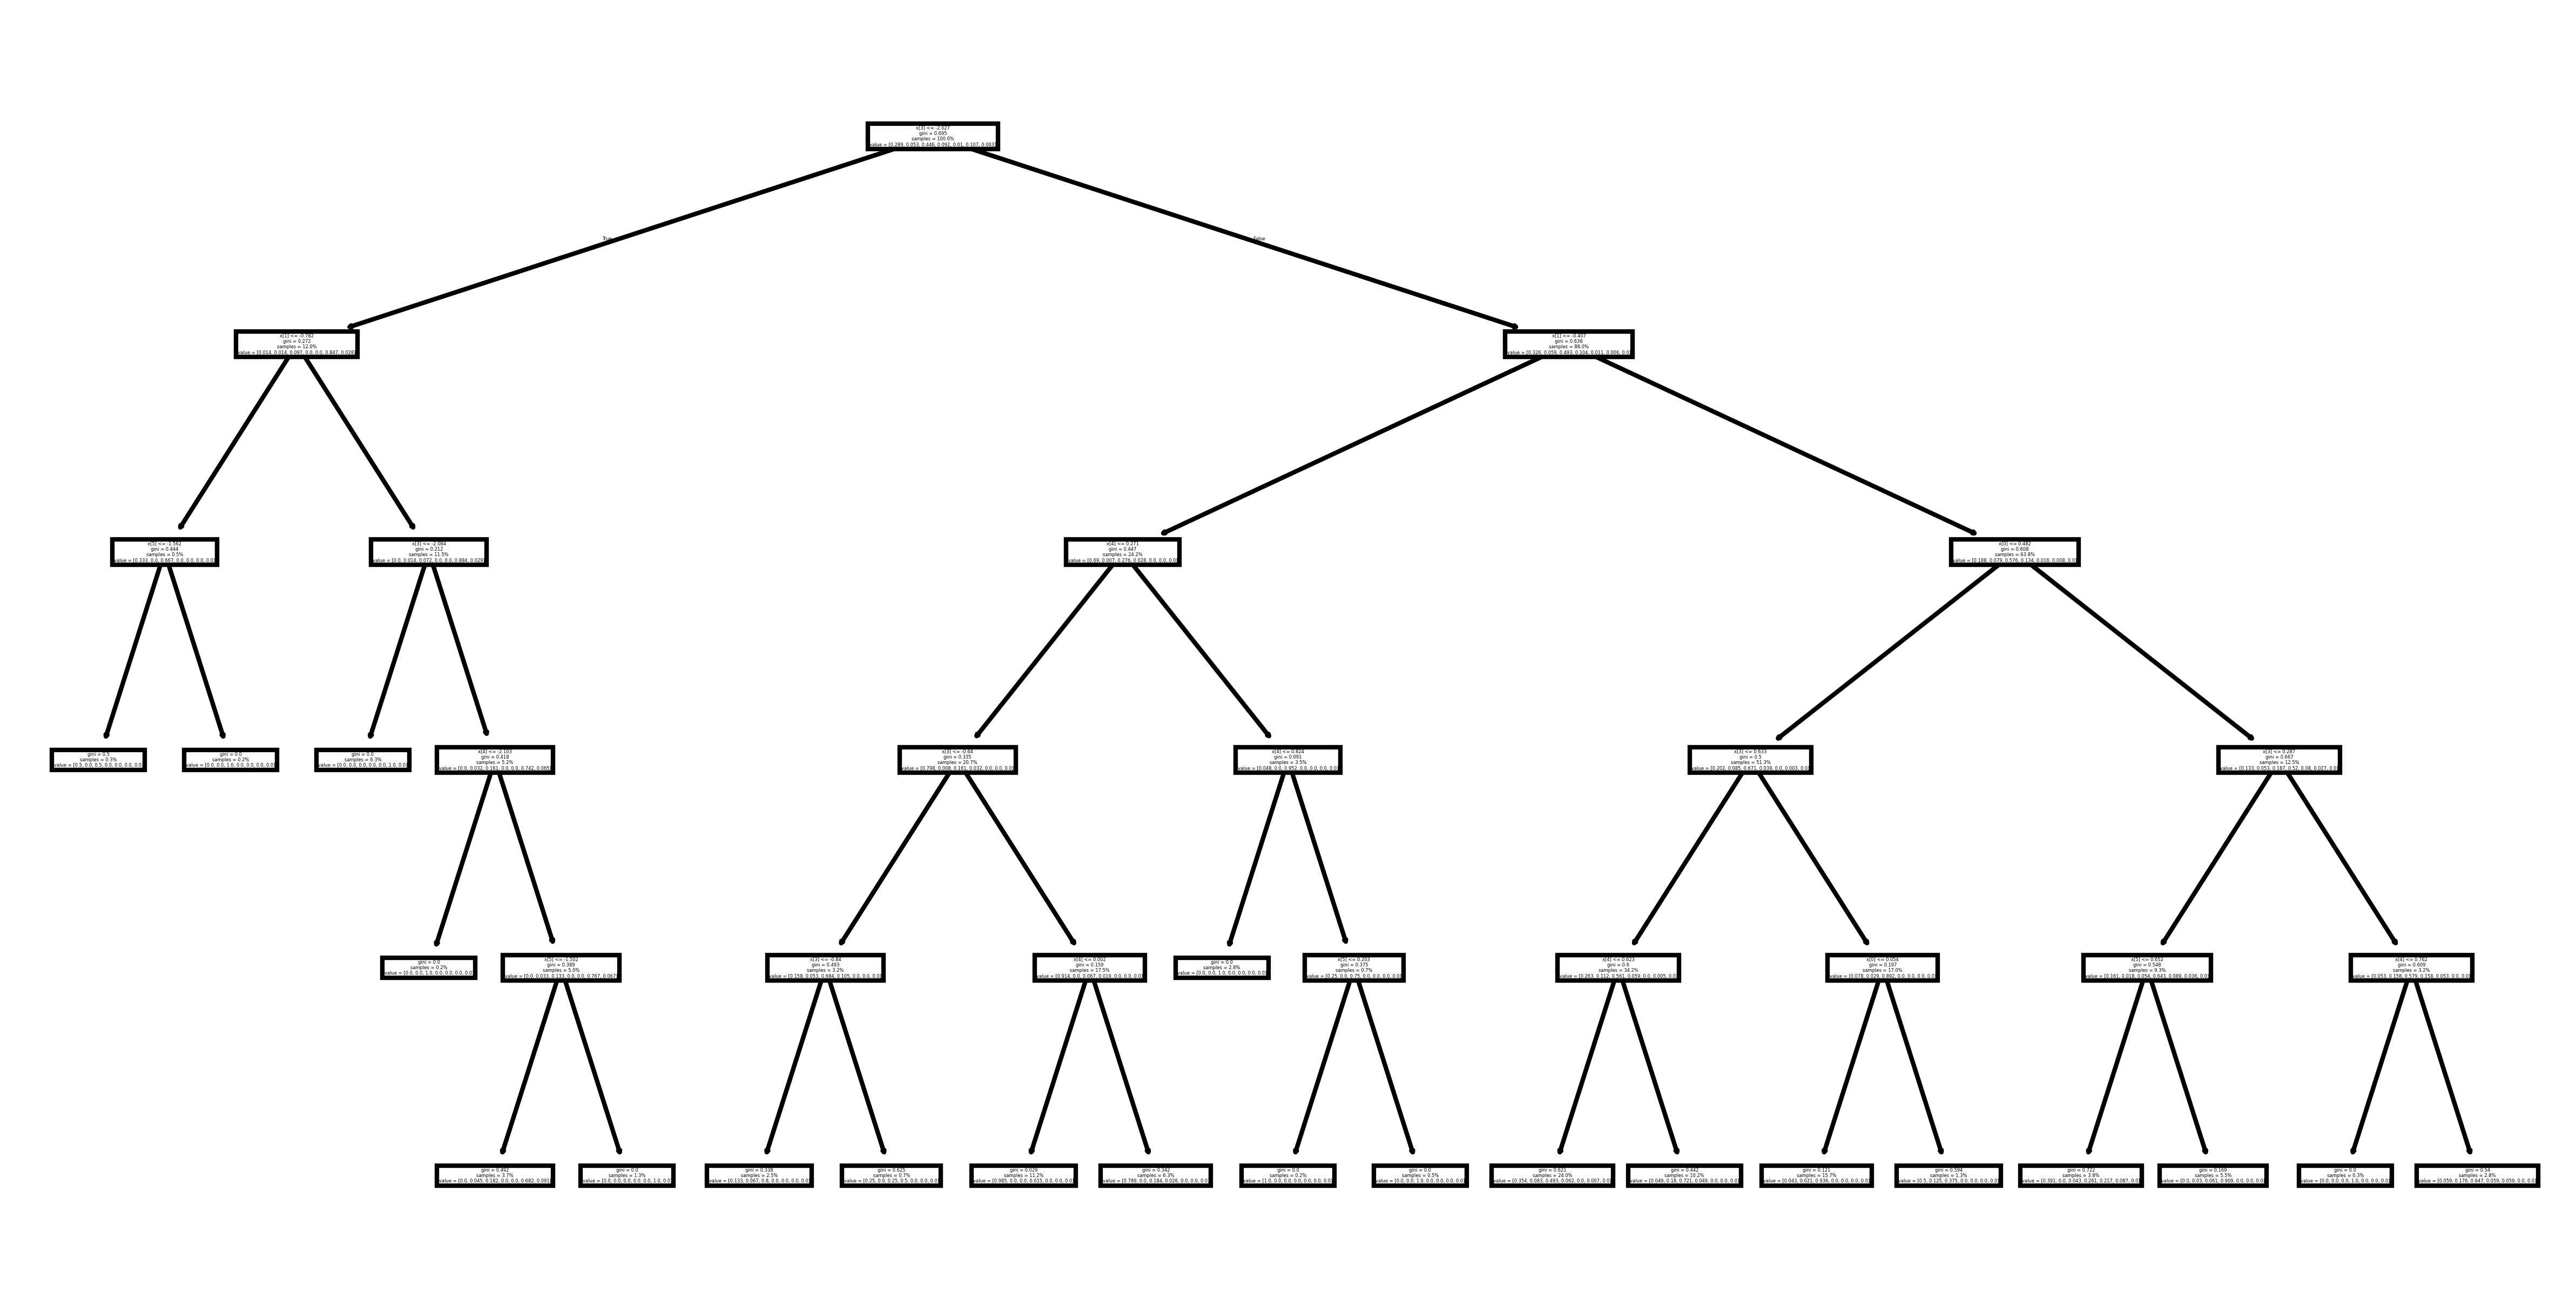

In [412]:
from sklearn.tree import plot_tree

plt.figure(figsize=(10, 5),dpi=600)
plot_tree(tree, proportion=True)

plt.show()

Plot the confution matrix of tree model

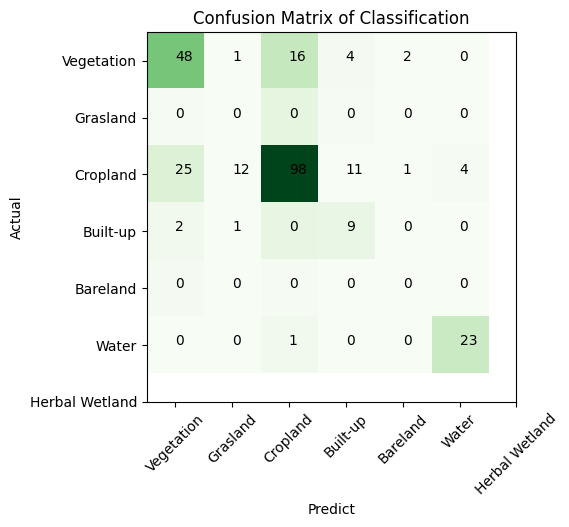

In [413]:
cm_tree = confusion_matrix(y_test, tree_pred)

plt.imshow(cm_tree, cmap='Greens') # Show the colormap first

for i in range(cm_tree.shape[0]): # for each row
    
    for j in range(cm_tree.shape[1]): # for each col
        
        plt.text(i, j, cm_tree[i, j]) # plot text of counts
        
plt.xticks(np.arange(len(labels)), labels, rotation=45) # define x labels
plt.yticks(np.arange(len(labels)), labels) # define y labels
        
plt.xlabel('Predict') # set x label
plt.ylabel('Actual') # set y label

plt.title('Confusion Matrix of Classification') # set title

plt.show()

##  Random Forest

Instantiate the Random Forest model and Fit the model

In [414]:
forest = RandomForestClassifier()

forest.fit(X_train, y_train)

RandomForestClassifier()

Predict outputs using trained model

In [415]:
forest_pred = forest.predict(X_test)

Examine classification metric

In [416]:
print(classification_report(y_test, forest_pred))

              precision    recall  f1-score   support

           1       0.66      0.69      0.68        75
           3       0.00      0.00      0.00        14
           4       0.71      0.79      0.75       115
           5       0.65      0.46      0.54        24
           6       0.14      0.33      0.20         3
           8       0.92      0.89      0.91        27

    accuracy                           0.69       258
   macro avg       0.51      0.53      0.51       258
weighted avg       0.67      0.69      0.68       258



Plot confusion matrix

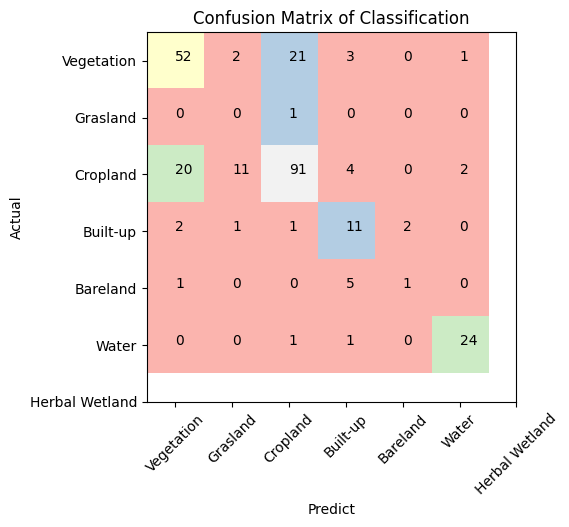

In [417]:
cm_forest = confusion_matrix(y_test, forest_pred)

plt.imshow(cm_forest, cmap='Pastel1') # Show the colormap first

for i in range(cm_forest.shape[0]): # for each row
    
    for j in range(cm_forest.shape[1]): #s for each col
        
        plt.text(i, j, cm_forest[i, j]) # plot text of counts
        
plt.xticks(np.arange(len(labels)), labels, rotation=45) # define x labels
plt.yticks(np.arange(len(labels)), labels) # define y labels
        
plt.xlabel('Predict') # set x label
plt.ylabel('Actual') # set y label

plt.title('Confusion Matrix of Classification') # set title

plt.show()

However, every model we did is default configuration. We can do searching for best combination of hyperparameters settings for best estimator.

In [418]:
# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 9],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}


Apply __GridSearchCV__ tool with hyperparameters and fit the model similar to normal model

In [419]:

# Create a Random Forest Classifier
rf_clf = RandomForestClassifier()

# Perform Grid Search CV
grid_search = GridSearchCV(rf_clf, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)


/opt/anaconda3/envs/ttg-tes/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/opt/anaconda3/envs/ttg-tes/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 5, 9],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

The result will show the best hyperparameter setting for the model

In [420]:

# Print best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'max_depth': 9, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best score: 0.7378726968174204


Examine the classification metric

In [421]:
print(classification_report(y_test, grid_search.predict(X_test)))


              precision    recall  f1-score   support

           1       0.65      0.68      0.67        75
           3       0.00      0.00      0.00        14
           4       0.68      0.80      0.73       115
           5       0.69      0.46      0.55        24
           6       0.25      0.33      0.29         3
           8       0.96      0.85      0.90        27

    accuracy                           0.69       258
   macro avg       0.54      0.52      0.52       258
weighted avg       0.66      0.69      0.67       258



/opt/anaconda3/envs/ttg-tes/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/ttg-tes/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/ttg-tes/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Check the confusion matrix with best estimator

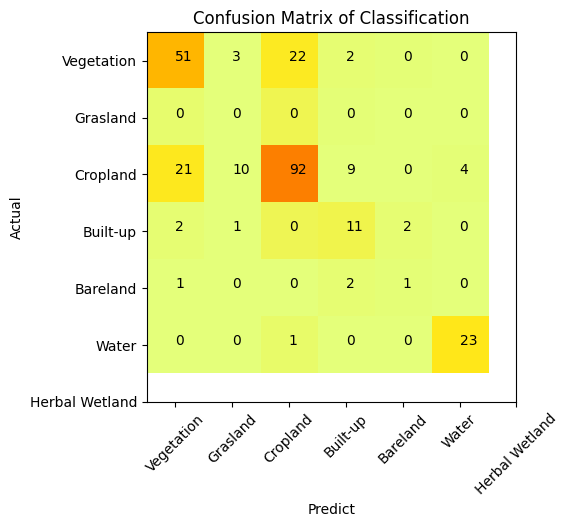

In [422]:
cm_grid =  confusion_matrix(y_test, grid_search.predict(X_test))

plt.imshow(cm_grid, cmap='Wistia') # Show the colormap first

for i in range(cm_grid.shape[0]): # for each row
    
    for j in range(cm_grid.shape[1]): #s for each col
        
        plt.text(i, j, cm_grid[i, j]) # plot text of counts
        
plt.xticks(np.arange(len(labels)), labels, rotation=45) # define x labels
plt.yticks(np.arange(len(labels)), labels) # define y labels
        
plt.xlabel('Predict') # set x label
plt.ylabel('Actual') # set y label

plt.title('Confusion Matrix of Classification') # set title

plt.show()

## Support Vector Machine

SVM model is not much that difficult if it is not apply other kernels. It is another linear model $W^TX + b$ that assume to have a line to sperate the 2 classes out. The hypothesis function is as same as linear but recognize the sign of answer from the calculation. If the sign of result is negative it means to one class depite positive for another class

![](https://www.cs.cornell.edu/courses/cs4780/2015fa/web/lecturenotes/images/svm/c6.png)

For more imagination, we randomize the `W` and `b` for the purpose

In [537]:
W = np.random.rand(X_train.shape[1])
b = np.random.rand()

W, b

(array([0.919, 0.914, 0.887, 0.138, 0.613, 0.711]), 0.2130658902204008)

Apply linear algebra to the equation

In [538]:
approx = X_train[:10] @ W + b

Measure the output class by just only a sign (+, -) to indicates to class label

In [539]:
np.sign(approx)

array([-1., -1.,  1.,  1.,  1., -1., -1.,  1., -1., -1.])

Try the real one

In [ ]:
svm = SVC()

svm.fit(X_train, y_train)

SVC()

Predict outputs using trained SVM

In [ ]:
svm_pred = svm.predict(X_test)

Check classification metric

In [ ]:
print(classification_report(y_test, svm_pred))

              precision    recall  f1-score   support

           1       0.78      0.52      0.62        75
           3       0.00      0.00      0.00        14
           4       0.63      0.82      0.71       115
           5       0.50      0.46      0.48        24
           6       0.00      0.00      0.00         3
           8       0.75      1.00      0.86        27

    accuracy                           0.66       258
   macro avg       0.44      0.47      0.44       258
weighted avg       0.63      0.66      0.63       258



/opt/anaconda3/envs/ttg-tes/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/ttg-tes/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/ttg-tes/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Checl confusion matrix

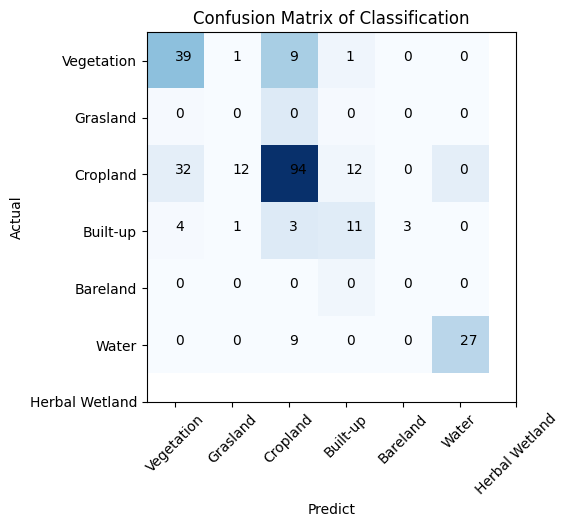

In [ ]:
cm_svm = confusion_matrix(y_test, svm_pred)

plt.imshow(cm_svm, cmap='Blues') # Show the colormap first

for i in range(cm_svm.shape[0]): # for each row
    
    for j in range(cm_svm.shape[1]): #s for each col
        
        plt.text(i, j, cm_svm[i, j]) # plot text of counts
        
plt.xticks(np.arange(len(labels)), labels, rotation=45) # define x labels
plt.yticks(np.arange(len(labels)), labels) # define y labels
        
plt.xlabel('Predict') # set x label
plt.ylabel('Actual') # set y label

plt.title('Confusion Matrix of Classification') # set title

plt.show()

However, the SVM is not only this. there are some special hyperparameters like `kernel` which mathematically transforms the `X` into new feature space or new additional axis. This helps a lot to recognize the non-linearity of the inputs. 


![](https://media.licdn.com/dms/image/C5612AQFwr9O_mtmgXQ/article-cover_image-shrink_720_1280/0/1564864779122?e=2147483647&v=beta&t=s7ZvgR3oYuolDwB9_wQFY1VYAv0afBxp5MCrbhogO_E)

This is example illustration of SVM's RBF kernel

![](https://miro.medium.com/v2/resize:fit:769/1*feXl-jWdfcgtWK61yLUDRQ.png)

We have tried the RF as GridSearchCV, now we will do it with SVM. declare the grid parameters of SVM first

In [155]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'C': [1, 10, 100],          # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],     # Kernels to try
    'gamma': ['scale', 'auto', 1, 10],  # Kernel coefficient
    'degree': [2, 3],             # Only relevant for 'poly' kernel
}

Perform K-Fold GridSearchCV

In [160]:
# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=SVC(max_iter=10000),
    param_grid=param_grid,
    cv=3,  # 5-fold cross-validation
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

# Fit the model on the training data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV] END ..........C=1, degree=2, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ..........C=1, degree=2, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ..........C=1, degree=2, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ............C=1, degree=2, gamma=scale, kernel=poly; total time=   0.0s
[CV] END .............C=1, degree=2, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ............C=1, degree=2, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ............C=1, degree=2, gamma=scale, kernel=poly; total time=   0.0s
[CV] END .............C=1, degree=2, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ...........C=1, degree=2, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ...........C=1, degree=2, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .............C=1, degree=2, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .............C=1, degree=2, gamma=auto

/opt/anaconda3/envs/ttg-tes/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/opt/anaconda3/envs/ttg-tes/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/envs/ttg-tes/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/envs/ttg-tes/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/envs/ttg-tes/lib/python3.10/site-packages/sklearn/svm/_base.py:297: Converg

[CV] END .............C=10, degree=2, gamma=1, kernel=linear; total time=   0.0s
[CV] END ..........C=10, degree=2, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .........C=10, degree=2, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ............C=10, degree=2, gamma=auto, kernel=poly; total time=   0.0s
[CV] END ...........C=10, degree=2, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ............C=10, degree=2, gamma=10, kernel=linear; total time=   0.0s
[CV] END ............C=10, degree=2, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ................C=1, degree=3, gamma=10, kernel=rbf; total time=   0.0s
[CV] END ................C=10, degree=2, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...........C=10, degree=2, gamma=scale, kernel=poly; total time=   0.1s
[CV] END ...............C=1, degree=3, gamma=10, kernel=poly; total time=   0.1s
[CV] END ...............C=10, degree=2, gamma=1, kernel=poly; total time=   0.1s
[CV] END ................C=1

/opt/anaconda3/envs/ttg-tes/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/envs/ttg-tes/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/envs/ttg-tes/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/envs/ttg-tes/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/envs/ttg-tes/lib/python3.10/site-packages/sklearn

[CV] END ............C=10, degree=3, gamma=10, kernel=linear; total time=   0.0s
[CV] END ..........C=100, degree=2, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ..............C=10, degree=2, gamma=10, kernel=poly; total time=   0.0s
[CV] END .........C=100, degree=2, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ............C=100, degree=2, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ...........C=100, degree=2, gamma=auto, kernel=poly; total time=   0.0s
[CV] END .........C=100, degree=2, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ............C=100, degree=2, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ...........C=100, degree=2, gamma=auto, kernel=poly; total time=   0.0s
[CV] END ............C=100, degree=2, gamma=1, kernel=linear; total time=   0.0s
[CV] END ............C=100, degree=2, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ...............C=100, degree=2, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........C=100, deg

/opt/anaconda3/envs/ttg-tes/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/envs/ttg-tes/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/envs/ttg-tes/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/envs/ttg-tes/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/envs/ttg-tes/lib/python3.10/site-packages/sklearn

[CV] END .............C=100, degree=3, gamma=10, kernel=poly; total time=   0.0s
[CV] END .............C=100, degree=3, gamma=10, kernel=poly; total time=   0.0s


/opt/anaconda3/envs/ttg-tes/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


GridSearchCV(cv=3, estimator=SVC(max_iter=10000), n_jobs=-1,
             param_grid={'C': [1, 10, 100], 'degree': [2, 3],
                         'gamma': ['scale', 'auto', 1, 10],
                         'kernel': ['linear', 'rbf', 'poly']},
             scoring='accuracy', verbose=2)

Show best params

In [161]:
# Display the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

Best Parameters: {'C': 100, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
Best Cross-Validation Score: 0.7111725293132328


Show classification report

In [162]:
print(classification_report(y_test, grid_search.predict(X_test)))

              precision    recall  f1-score   support

           1       0.78      0.72      0.75        75
           3       0.00      0.00      0.00        14
           4       0.73      0.86      0.79       115
           5       0.65      0.54      0.59        24
           6       0.00      0.00      0.00         3
           8       0.87      0.96      0.91        27

    accuracy                           0.74       258
   macro avg       0.50      0.51      0.51       258
weighted avg       0.70      0.74      0.72       258



Show confusion matrix

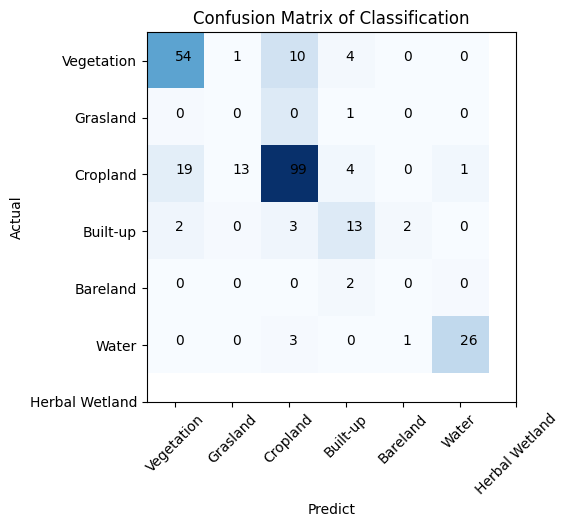

In [163]:
cm_svm = confusion_matrix(y_test, grid_search.predict(X_test))

plt.imshow(cm_svm, cmap='Blues') # Show the colormap first

for i in range(cm_svm.shape[0]): # for each row
    
    for j in range(cm_svm.shape[1]): #s for each col
        
        plt.text(i, j, cm_svm[i, j]) # plot text of counts
        
plt.xticks(np.arange(len(labels)), labels, rotation=45) # define x labels
plt.yticks(np.arange(len(labels)), labels) # define y labels
        
plt.xlabel('Predict') # set x label
plt.ylabel('Actual') # set y label

plt.title('Confusion Matrix of Classification') # set title

plt.show()

### Model Manipulation

After long journey of model training, there is one of ways to save the model 

In [164]:
import pickle

for simply save the model, create functions to do it

In [165]:
def save_model(model, filename):
    
    pickle.dump(model, open(filename, 'wb'))

def load_model(filename):
    
    return pickle.load(open(filename, 'rb'))

To save the model

In [166]:
save_model(model, 'logistic_reg.pkl')

Suppose to load the model from file

In [167]:
model = load_model('logistic_reg.pkl')

Test model prediction

In [168]:
model.predict(X_test)

array([5, 1, 1, 4, 1, 4, 8, 4, 4, 8, 8, 4, 1, 5, 1, 5, 1, 8, 4, 4, 4, 4,
       4, 5, 1, 4, 5, 4, 1, 4, 4, 4, 4, 4, 4, 4, 5, 4, 1, 4, 4, 4, 1, 4,
       4, 5, 1, 1, 4, 4, 1, 1, 4, 4, 8, 1, 4, 4, 4, 8, 4, 1, 8, 4, 4, 4,
       4, 4, 4, 1, 1, 8, 4, 4, 4, 1, 4, 8, 5, 4, 4, 5, 4, 4, 8, 4, 4, 4,
       4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 1, 4, 1, 5, 4, 1, 8, 4, 4, 4, 5, 4,
       4, 5, 4, 4, 1, 8, 4, 4, 1, 4, 4, 4, 4, 8, 1, 4, 4, 4, 4, 8, 4, 4,
       4, 5, 8, 4, 4, 8, 8, 4, 1, 4, 4, 4, 4, 4, 4, 4, 8, 8, 4, 4, 4, 1,
       4, 8, 4, 4, 4, 4, 1, 4, 1, 4, 4, 1, 4, 5, 8, 4, 4, 4, 8, 4, 8, 5,
       8, 4, 4, 4, 1, 1, 4, 1, 4, 8, 4, 8, 4, 1, 4, 4, 4, 4, 4, 4, 4, 1,
       4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 1, 5, 4, 5, 4, 4, 8, 5, 8, 4, 1, 4,
       1, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 5, 1,
       4, 4, 1, 1, 1, 1, 8, 4, 8, 4, 8, 4, 1, 4, 5, 1], dtype=int32)

## Map Inferencing

This is a step to actual mapping of LULC data. we need to load all of raster data each bands into a datacube to transform dataset into model predictable form. Start from load all raster data

In [169]:
datacube = []

for image_file in image_files:

    with rasterio.open(image_file) as src:
        
        datacube.append(src.read(1))
        
        image_profile = src.profile
        

Check the shape of data

In [170]:
for cube in datacube:
    print(cube.shape)

(390, 422)
(390, 422)
(390, 422)
(390, 422)
(196, 212)
(196, 212)


Try to plot one of data map

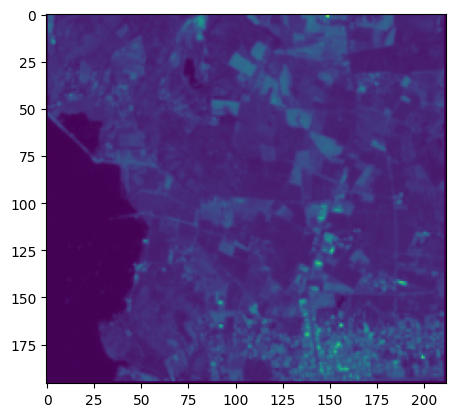

In [171]:
plt.imshow(cube)

SWIR bands are not perfectly aligned to others. do resample with zoom for image to adjust image dimension

In [172]:
from scipy import ndimage

def resample_with_zoom(arr, new_shape):
    zoom_factor = np.array(new_shape) / np.array(arr.shape)
    return ndimage.zoom(arr, zoom_factor, order=1)  # Adjust order for different interpolation

Implement to every single band

In [173]:
datacube = [resample_with_zoom(cube, (390, 422)) for cube in datacube]

Convert list-based to numpy-based datacube

In [174]:
datacube = np.dstack(datacube)
datacube.shape

(390, 422, 6)

The shape of data is ready to predict using loaded model. Then, we have to flatten the data cube into model readable

In [175]:
datacube_x = datacube.reshape(-1, 6)

Check the shape

In [176]:
datacube_x.shape

(164580, 6)

Transform the scaler for datacube since we train the model with scaled data

In [177]:
datacube_x_scaled = scaler.transform(datacube_x)

/opt/anaconda3/envs/ttg-tes/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Apply predict directly

In [178]:
lulc = model.predict(datacube_x_scaled)

Reshape the output back to original shape

In [179]:
lulc_map = lulc.reshape(390, 422)

Try to plot the image map

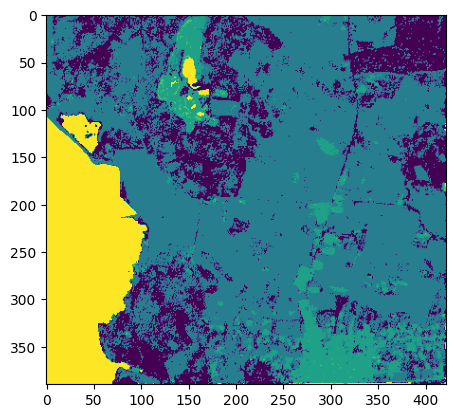

In [180]:
plt.imshow(lulc_map)

Save the file by below code

In [181]:
save_map_to = 'lulc_map.tif'

image_profile.update({"driver": "GTiff",
                    "height": lulc_map.shape[0],
                    "width": lulc_map.shape[1]})
    
# Save the clipped raster
with rasterio.open(save_map_to, "w", **image_profile) as dest:
    dest.write(lulc_map[np.newaxis,:,:])
        

## KMeans Clustering Method

This way of classification is unsupervised model which no need labels data to guide the algorithm.

We can define target number of classes in advanced and let the model grouping spectral signature themselves

In [182]:
from sklearn.cluster import KMeans

Suppose we expect to have 8 classes, we can call the model and train without put `y`

In [183]:
kmean = KMeans(n_clusters=8)

kmean.fit(datacube_x_scaled)

kmean_pred = kmean.predict(datacube_x_scaled)

After prediction, reshape the output back to original dimension

In [184]:
kmean_map = kmean_pred.reshape(390, 422)

Try to plot the image map

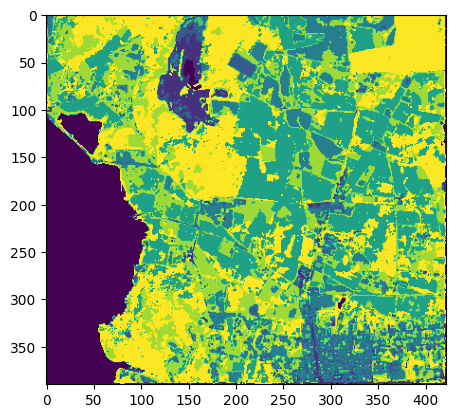

In [185]:
plt.imshow(kmean_map)

Until this step, Clustering method is usually to be used in pre-observation step. Some time it may be used in explore simialar samples to the existing reference data on ground. This helps to have more samples for training